<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [38]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
# mms = MinMaxScaler()
mms = StandardScaler()   
import numpy as np
import statsmodels.api as sm
import patsy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, SGDClassifier
sns.set_style('whitegrid')
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [21]:
# Load the data
df = pd.read_csv('./housing.csv')

# Let's have a look at the dataset.

In [22]:
print df.head()
print df.shape
print df.isnull().sum() # Any null values?

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [23]:
df.describe(include = [np.number]) # describe metric datas only

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [24]:
df.describe(include = ['O'])  # describle categorical columns only

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


# How about the SalePrice ?

In [6]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Let's see sales price over the years.

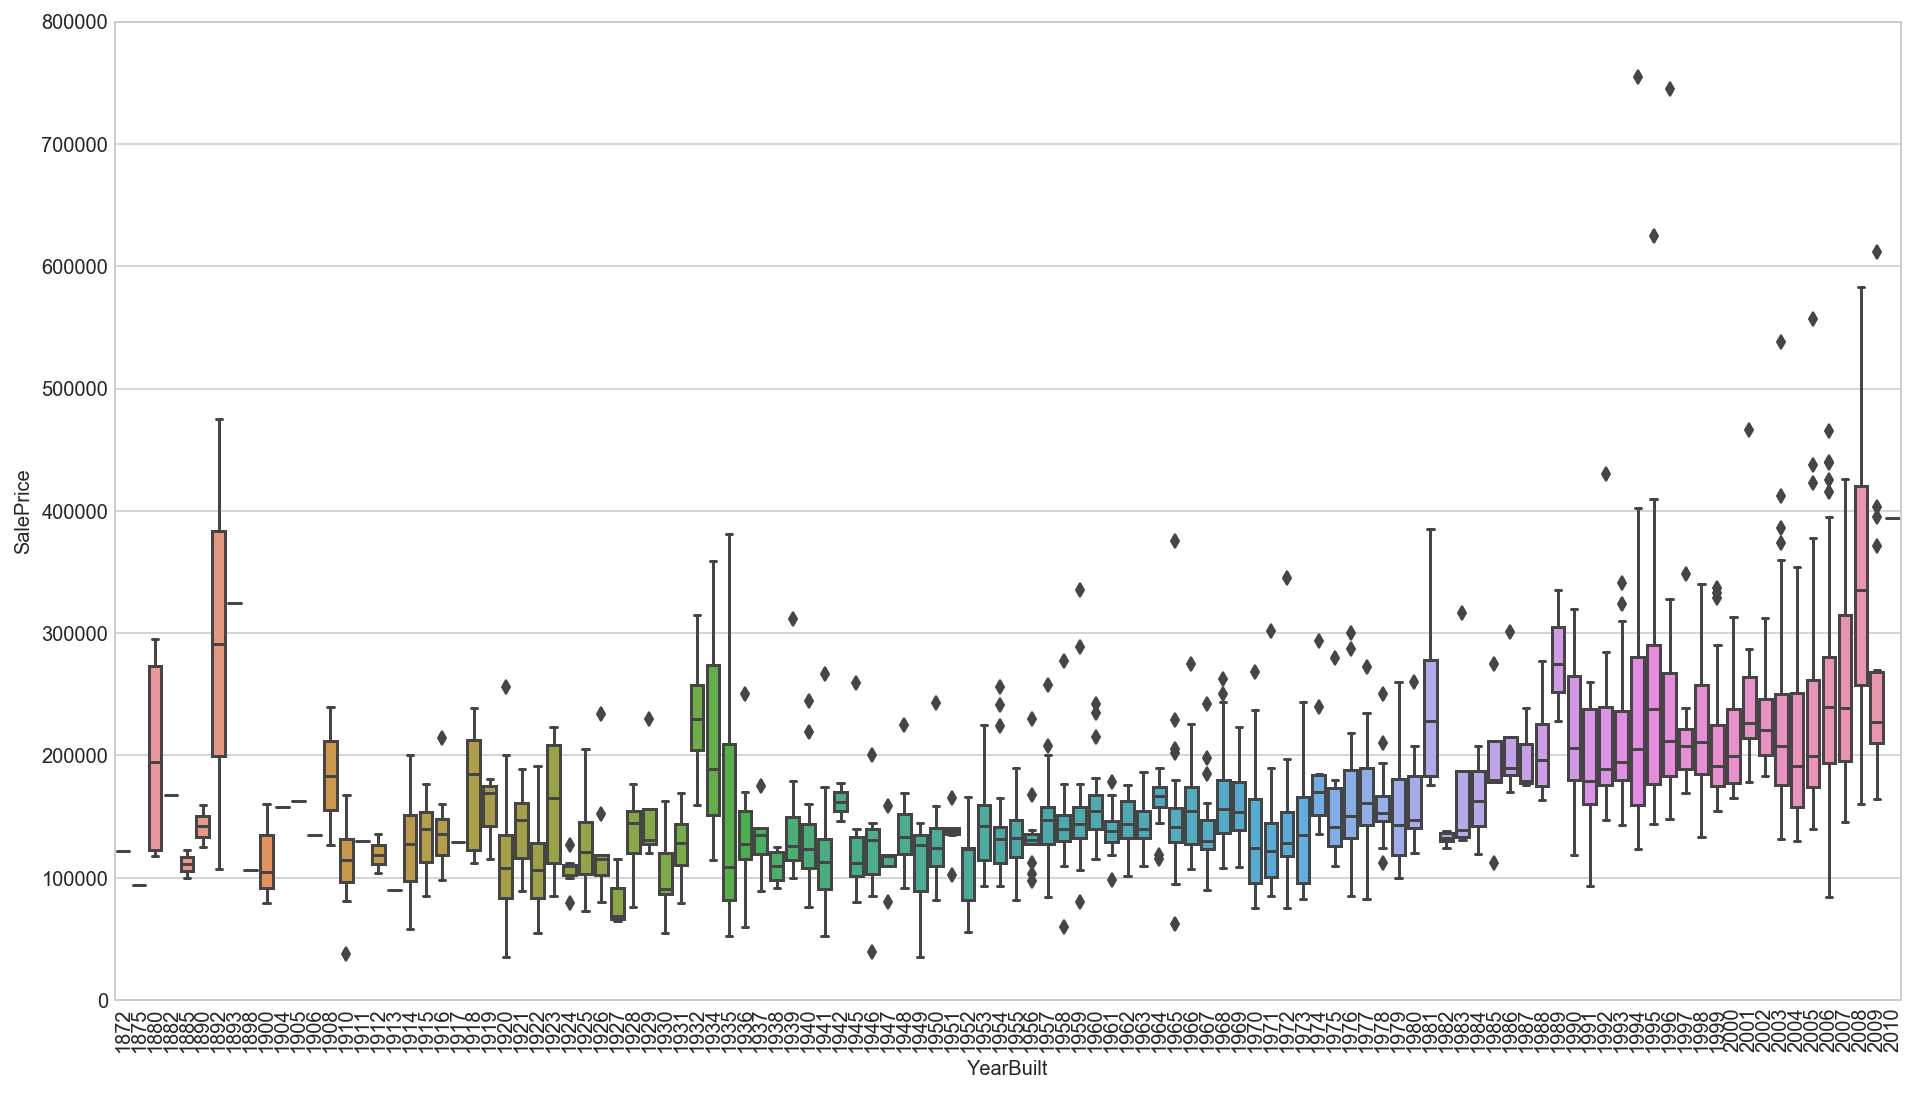

In [7]:
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 9))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);


# Data cleaning

In [8]:
df = pd.read_csv('./housing.csv')
df_clean = df   #.select_dtypes(exclude=[object])
print "Before cleaning df_clean.shape = " , df_clean.shape

# # Drop columns with 80% null values
# thresh = len(df_numeric) * 0.2                                  
# df_clean.dropna(thresh = thresh, axis = 1, inplace = True)  

df_clean.loc[df_clean["LotFrontage"].isnull(), "LotFrontage"] = 0

# Replace Null values with SOMETHING
df_clean.BsmtQual.replace(np.nan, 'NOBsm', regex=True, inplace=True)         
df_clean.BsmtCond.replace(np.nan, 'NOBsm', regex=True, inplace=True)
df_clean.BsmtExposure.replace(np.nan, 'NOBsm', regex=True, inplace=True)
df_clean.BsmtFinType1.replace(np.nan, 'NOBsm', regex=True, inplace=True)
df_clean.BsmtFinType2.replace(np.nan, 'NOBsm', regex=True, inplace=True)

df_clean.GarageType.replace(np.nan, 'NOGarg', regex=True, inplace=True)
df_clean.GarageFinish.replace(np.nan, 'NOGarg', regex=True, inplace=True)
df_clean.GarageQual.replace(np.nan, 'NOGarg', regex=True, inplace=True)
df_clean.GarageCond.replace(np.nan, 'NOGarg', regex=True, inplace=True)

df_clean.MasVnrType.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Electrical.replace(np.nan, 'SBrkr', regex=True, inplace=True) #SBrkr 'None' has more.


df_clean.RoofStyle.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.RoofMatl.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Exterior1st.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Exterior2nd.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.ExterQual.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.ExterCond.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Foundation.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Heating.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.HeatingQC.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.CentralAir.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Electrical.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.KitchenQual.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.Functional.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.
df_clean.FireplaceQu.replace(np.nan, 'None', regex=True, inplace=True)  #Bcos 'None' has more.


# Fence also too few data, many Nan, replace to binary
df_clean.loc[df_clean["Fence"].notnull(), "Fence"] = 1
df_clean.loc[df_clean["Fence"].isnull(), "Fence"] = 0

# MiscFeature replace to binary
df_clean.loc[df_clean["MiscFeature"].notnull(), "MiscFeature"] = 1
df_clean.loc[df_clean["MiscFeature"].isnull(), "MiscFeature"] = 0

# FireplaceQu replace to binary
df_clean.loc[df_clean["FireplaceQu"].notnull(), "FireplaceQu"] = 1
df_clean.loc[df_clean["FireplaceQu"].isnull(), "FireplaceQu"] = 0

# PoolQC only 7 data,1453 is NaN replace to binary, got pool and no pool
df_clean.loc[df_clean["PoolQC"].notnull(), "PoolQC"] = 1
df_clean.loc[df_clean["PoolQC"].isnull(), "PoolQC"] = 0

df_clean.loc[df_clean["Alley"].notnull(), "Alley"] = 1
df_clean.loc[df_clean["Alley"].isnull(), "Alley"] = 0

# Remove  commercial properties
comm_filter = df_clean["MSZoning"] == "C (all)"
df_clean = df_clean[~comm_filter]
df_clean.reset_index(drop=True)

#Since most common value in the column is None, let's fill the missing values with "None"
df_clean.loc[df_clean["MasVnrType"].isnull(), "MasVnrType"] = 'None'

# Replace Null cells with mean
df_clean.fillna(df_clean.mean(), inplace = True)

# Remove rows with null value.
df_clean.dropna( axis = 0, how='any', inplace = True) 

print "Before cleaning df_clean.shape  = " , df_clean.shape

df = df_clean

Before cleaning df_clean.shape =  (1460, 81)


C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Before cleaning df_clean.shape  =  (1450, 81)


C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Feature Selection, Separate by human , renovatable or not_renovatable

In [9]:
renovatable = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
               'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',  'HeatingQC', 'Electrical',  'LowQualFinSF',
               'KitchenQual', 'Functional','GarageQual', 'GarageCond','SalePrice', 'YrSold'] 
# Removed  'FireplaceQu' ,'PoolQC', 'Fence' during cleaning


not_renovatable = ['MSSubClass', 'LotArea', 'LotFrontage', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
                  'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                  'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea',  'Foundation',  'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinSF1', 'BsmtFinType2','BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', 'Heating', 'CentralAir',  
                   '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',  'BsmtHalfBath', 'FullBath',  'HalfBath', 'BedroomAbvGr', 
                  'KitchenAbvGr'  , 'TotRmsAbvGrd', 'Fireplaces',  'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
                   'GarageArea','PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',  'ScreenPorch', 'PoolArea',
                   'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']



# DataFrame 1) renovatable  2) NOT renovatable features

In [10]:
# Preparing df for NOT renovateable features
df_notreno = df[not_renovatable]                               # Giving a diff name in case messed up df.
df_cat = df_notreno.select_dtypes(include=[object])            # SPlit cats only
df_numeric = df_notreno.select_dtypes(exclude=[object])        # Splits num only  
df_cat_dummy = pd.get_dummies(df_cat, drop_first=True)         #   Dummies all cats
df_notreno = pd.concat([df_numeric , df_cat_dummy],  axis=1)   # Merge back togather numeric with cats
df_train_notreno_b4_2010 = df_notreno[df_notreno.YrSold < 2010] # SPlit df before 2010  NOT renovatable
df_test_notreno_2010 = df_notreno[df_notreno.YrSold == 2010]    # SPlit df after 2010   NOT renovatable
print df_train_notreno_b4_2010.shape
print df_test_notreno_2010.shape

(1278, 155)
(172, 155)


In [63]:
# Preparing df for renovateable features
df_reno = df[renovatable]                               # Giving a diff name in case messed up df.
df_cat = df_reno.select_dtypes(include=[object])            # SPlit cats only
df_numeric = df_reno.select_dtypes(exclude=[object])        # Splits num only  
df_cat_dummy = pd.get_dummies(df_cat, drop_first=True)         #   Dummies all cats
df_reno = pd.concat([df_numeric , df_cat_dummy],  axis=1)   # Merge back togather numeric with cats
df_train_reno_b4_2010 = df_reno[df_reno.YrSold < 2010] # SPlit df before 2010 renovatable
df_test_reno_2010 = df_reno[df_reno.YrSold == 2010]    # SPlit df after 2010  renovatable
print df_train_reno_b4_2010.shape
print df_test_reno_2010.shape

(1285, 84)
(175, 84)


# Split - Train - Test sets

In [25]:
# NOT RENOVATABLE + BEFORE 2010, Train set
y_train_notreno_b4_2010 = df_train_notreno_b4_2010[["SalePrice"]].values
X_train_notreno_b4_2010 = df_train_notreno_b4_2010.drop("SalePrice", axis=1).values
Xs_train_notreno_b4_2010 = mms.fit_transform(X_train_notreno_b4_2010)

# NOT RENOVATABLE + AFTER 2010, TEST set
y_test_notreno_2010 = df_test_notreno_2010[["SalePrice"]].values
X_test_notreno_2010 = df_test_notreno_2010.drop("SalePrice", axis=1).values
Xs_test_notreno_2010 = mms.fit_transform(X_test_notreno_2010)

y_train_notreno_b4_2010 = y_train_notreno_b4_2010.flatten(order='C')
y_test_notreno_2010 = y_test_notreno_2010.flatten(order='C')

print y_train_notreno_b4_2010.shape
print Xs_train_notreno_b4_2010.shape
print y_test_notreno_2010.shape
print Xs_test_notreno_2010.shape


(1278L,)
(1278L, 154L)
(172L,)
(172L, 154L)


In [26]:
# RENOVATABLE + BEFORE 2010, Train set
y_train_reno_b4_2010 = df_train_reno_b4_2010[["SalePrice"]].values
X_train_reno_b4_2010 = df_train_reno_b4_2010.drop("SalePrice", axis=1).values
Xs_train_reno_b4_2010 = mms.fit_transform(X_train_reno_b4_2010)

# RENOVATABLE + AFTER 2010, TEST set
y_test_reno_2010 = df_test_reno_2010[["SalePrice"]].values
X_test_reno_2010 = df_test_reno_2010.drop("SalePrice", axis=1).values
Xs_test_reno_2010 = mms.fit_transform(X_test_reno_2010)

y_train_reno_b4_2010 = y_train_reno_b4_2010.flatten(order='C')
y_test_reno_2010 = y_test_reno_2010.flatten(order='C')

print y_train_reno_b4_2010.shape
print Xs_train_reno_b4_2010.shape
print y_test_reno_2010.shape
print Xs_test_reno_2010.shape


(1278L,)
(1278L, 87L)
(172L,)
(172L, 87L)


# Baseline Modeling  NOT RENOVATABLE + BEFORE 2010

In [27]:
lr_notreno = LinearRegression()
lr_lasso_notreno = Lasso(random_state=0, alpha=500) # alpha 0 to 1
lr_ridge_notreno = Ridge(alpha=100)   # alpha 0 to 1
elast_notreno = ElasticNet(alpha=0.1, l1_ratio=0.1)   # alpha 0 to 1
svr_notreno = SVR(kernel='linear')  # almost the same as poly
dtr_notreno = DecisionTreeRegressor(random_state=0)
rfr_notreno = RandomForestRegressor(n_estimators = 10, random_state = 0) # number of trees 10. Pick random.
sgd_reg_notreno = SGDRegressor(random_state=0)

print 'LinearRegression     : ', cross_val_score(lr_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'Lasso                : ', cross_val_score(lr_lasso_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'Ridge                : ', cross_val_score(lr_ridge_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'ElasticNet           : ', cross_val_score(elast_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'SVR                  : ', cross_val_score(svr_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'DecisionTreeRegressor: ', cross_val_score(dtr_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'RandomForestRegressor: ', cross_val_score(rfr_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()
print 'SDGRegressor         : ', cross_val_score(sgd_reg_notreno, Xs_train_notreno_b4_2010, y_train_notreno_b4_2010, cv=10).mean()


LinearRegression     :  -3.0664373264964097e+26
Lasso                :  0.7888252920777197
Ridge                :  0.7901542086779024
ElasticNet           :  0.7904761109234593
SVR                  :  0.1347258766531057
DecisionTreeRegressor:  0.6386825425030406
RandomForestRegressor:  0.8203239416771504
SDGRegressor         :  0.6913331487027878


#### Random Forest Regressor performs the best here.
#### We shall use this as our baseline.

# Feature Selection

# There is a few methods of feature selection. Here I will try all that I know. LassoCV, K-Best, RFECV

In [15]:
Xs = Xs_train_notreno_b4_2010
y = y_train_notreno_b4_2010
# X= pd.DataFrame(Xs)
# type(X)
X = df_train_notreno_b4_2010.drop("SalePrice", axis=1)

# Feature Selection Method 1: LASSOCV 

In [16]:
print 'Before feature selection' , Xs.shape
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1, n_jobs=-1).fit(Xs, y)
lasso = Lasso(alpha=optimal_lasso.alpha_).fit(Xs, y)
Lasso_CVscore = cross_val_score(lasso, Xs, y, cv=10)
print 'Lasso Mean scores :' , Lasso_CVscore.mean()
print 'No. of features selected : ' , np.count_nonzero(lasso.coef_)

# Print out the selected features.
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)  })
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lassoCV_columns = lasso_coefs[lasso_coefs.abs_coef != 0].variable.values
print 'lassoCV_col : ',lassoCV_columns
lasso_coefs [lasso_coefs.abs_coef !=0]

Before feature selection (1278L, 154L)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso Mean scores : 0.7943025511771681
No. of features selected :  45
lassoCV_col :  ['GrLivArea' 'Neighborhood_NridgHt' 'GarageCars' 'Neighborhood_NoRidge'
 'Neighborhood_StoneBr' 'YearRemodAdd' 'MSSubClass' 'TotalBsmtSF'
 'BsmtFinType1_GLQ' 'SaleType_New' 'BsmtExposure_Gd' 'YearBuilt'
 'Fireplaces' 'Condition2_PosN' 'Neighborhood_Crawfor'
 'Neighborhood_Somerst' 'KitchenAbvGr' 'BsmtExposure_No' 'MasVnrArea'
 'Neighborhood_Edwards' 'LotArea' 'WoodDeckSF' 'ScreenPorch'
 'LotShape_IR3' 'Condition1_Feedr' 'BsmtFinSF1' 'Neighborhood_Veenker'
 'GarageFinish_Unf' 'LotConfig_CulDSac' 'BsmtFullBath' 'FullBath'
 'BldgType_Duplex' 'Condition2_PosA' 'Foundation_PConc' 'Condition1_Norm'
 'MSZoning_RM' 'LotShape_IR2' 'GarageFinish_RFn' 'TotRmsAbvGrd'
 'MasVnrType_Stone' 'GarageType_CarPort' 'Neighborhood_Mitchel'
 'SaleType_Con' 'LandContour_HLS' 'Condition1_RRAe']


,abs_coef,coef,variable
12,30409.202854,30409.202854,GrLivArea
65,12417.318927,12417.318927,Neighborhood_NridgHt
22,9805.264021,9805.264021,GarageCars
64,7753.000297,7753.000297,Neighborhood_NoRidge
71,6898.367487,6898.367487,Neighborhood_StoneBr
4,6865.755799,6865.755799,YearRemodAdd
0,6296.176710,-6296.176710,MSSubClass
9,5478.991043,5478.991043,TotalBsmtSF
113,5409.293131,5409.293131,BsmtFinType1_GLQ
146,5296.902541,5296.902541,SaleType_New


# Feature Selection Method 2: SelectKBest 

In [17]:
# SelectKBest, f_regression
from sklearn.feature_selection import SelectKBest, f_regression
f_reg= SelectKBest(f_regression, k=20)    # Noel, k is no. of top feature to select
f_reg.fit(Xs, y)                        
df_f_reg = pd.DataFrame([X.columns, list(f_reg.scores_)], 
                     index=['feature','f_reg']).T.sort_values('f_reg', ascending=False)
f_reg_columns = df_f_reg[df_f_reg.f_reg > 0].feature.values   # Noel choose 184.30, from scores, adjust accordingly

print 'f_reg scores :' , f_reg.scores_.mean()
print 'f_reg_columns :', f_reg_columns 
print 'No. of features selected : ' , f_reg_columns.size
df_f_reg.head(20)   # print df 

f_reg scores : 86.40213445250066
f_reg_columns : ['GrLivArea' 'GarageCars' 'GarageArea' 'TotalBsmtSF' '1stFlrSF' 'FullBath'
 'TotRmsAbvGrd' 'YearBuilt' 'YearRemodAdd' 'Foundation_PConc' 'MasVnrArea'
 'Fireplaces' 'GarageYrBlt' 'BsmtFinType1_GLQ' 'GarageFinish_Unf'
 'Neighborhood_NridgHt' 'BsmtFinSF1' 'MasVnrType_None' 'SaleType_New'
 'GarageType_Detchd' 'SaleCondition_Partial' 'Neighborhood_NoRidge'
 'MasVnrType_Stone' 'OpenPorchSF' 'WoodDeckSF' 'GarageType_Attchd'
 'Foundation_CBlock' '2ndFlrSF' 'BsmtExposure_Gd' 'MSZoning_RM' 'HalfBath'
 'BsmtExposure_No' 'LotShape_Reg' 'LotArea' 'HouseStyle_2Story'
 'SaleType_WD' 'CentralAir_Y' 'GarageFinish_NOGarg' 'GarageType_NOGarg'
 'PavedDrive_Y' 'GarageType_BuiltIn' 'MSZoning_RL' 'BsmtFullBath'
 'LotFrontage' 'BsmtUnfSF' 'Neighborhood_StoneBr' 'Neighborhood_NAmes'
 'Neighborhood_OldTown' 'MasVnrType_BrkFace' 'Neighborhood_Edwards'
 'SaleCondition_Normal' 'GarageFinish_RFn' 'BedroomAbvGr'
 'Neighborhood_BrkSide' 'BsmtFinType1_NOBsm' 'BsmtExposu

,feature,f_reg
12,GrLivArea,1284
22,GarageCars,894.937
23,GarageArea,844.791
9,TotalBsmtSF,731.737
10,1stFlrSF,711.931
15,FullBath,590.937
19,TotRmsAbvGrd,495.105
3,YearBuilt,453.593
4,YearRemodAdd,438.748
104,Foundation_PConc,387.207


In [18]:
# SelectKBest, mutual_info_regression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
mui_reg= SelectKBest(mutual_info_regression, k=20)    # Noel, k is no. of top feature to select
mui_reg.fit(Xs, y)                        
df_mui_reg = pd.DataFrame([X.columns, list(mui_reg.scores_)], 
                     index=['feature','mui_reg']).T.sort_values('mui_reg', ascending=False)
mui_reg_columns = df_mui_reg[df_mui_reg.mui_reg > 0].feature.values   # Noel choose 0.115, from scores, adjust accordingly

print 'mui_reg scores :' , mui_reg.scores_.mean()
print 'mui_reg_columns :', mui_reg_columns 
print 'No. of features selected : ' , mui_reg_columns.size
df_mui_reg.head(20)   # print df 

C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


mui_reg scores : 0.05137818543400027
mui_reg_columns : ['GrLivArea' 'YearBuilt' 'TotalBsmtSF' 'GarageCars' 'GarageArea'
 '1stFlrSF' 'GarageYrBlt' 'MSSubClass' 'FullBath' 'YearRemodAdd'
 '2ndFlrSF' 'LotFrontage' 'TotRmsAbvGrd' 'Foundation_PConc' 'OpenPorchSF'
 'Fireplaces' 'LotArea' 'GarageFinish_Unf' 'GarageType_Attchd'
 'BsmtFinSF1' 'WoodDeckSF' 'GarageType_Detchd' 'BsmtUnfSF' 'MasVnrArea'
 'BsmtFinType1_GLQ' 'MasVnrType_None' 'HalfBath' 'SaleType_New'
 'MSZoning_RM' 'Foundation_CBlock' 'GarageFinish_NOGarg'
 'GarageFinish_RFn' 'LotShape_Reg' 'Neighborhood_NridgHt'
 'SaleCondition_Partial' 'BedroomAbvGr' 'Neighborhood_NAmes'
 'CentralAir_Y' 'GarageType_NOGarg' 'MasVnrType_Stone'
 'Neighborhood_NoRidge' 'Neighborhood_CollgCr' 'HouseStyle_2Story'
 'Neighborhood_Gilbert' 'Neighborhood_Somerst' 'SaleType_WD' 'MSZoning_RL'
 'BsmtExposure_Gd' 'Neighborhood_OldTown' 'BsmtFullBath'
 'MasVnrType_BrkFace' 'PavedDrive_Y' 'BsmtExposure_NOBsm'
 'BsmtExposure_No' 'BsmtFinType2_NOBsm' 'KitchenAbvGr'

,feature,mui_reg
12,GrLivArea,0.475344
3,YearBuilt,0.360354
9,TotalBsmtSF,0.359549
22,GarageCars,0.35691
23,GarageArea,0.348555
10,1stFlrSF,0.306113
21,GarageYrBlt,0.300305
0,MSSubClass,0.291775
15,FullBath,0.261898
4,YearRemodAdd,0.226503


# Feature Selection Method 3: RFECV 

In [28]:
# Method 3: Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFECV(lr, step=1, cv=10, n_jobs=-1)  # step=% of features to remove, cv=no. of cross_validation folds for evalution.
rfe.fit(Xs, y)
# print selector.support_   # Output True/False
# print selector.ranking_   # Output  Ranking in Numbers
rfecv_columns = np.array(X.columns)[rfe.support_]
print 'No. of rfecv_columns:' , rfecv_columns.size
print 'rfecv_columns:' , rfecv_columns

No. of rfecv_columns: 33
rfecv_columns: ['LotArea' 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'LotShape_IR3'
 'Neighborhood_Crawfor' 'Neighborhood_NoRidge' 'Neighborhood_NridgHt'
 'Neighborhood_Somerst' 'Neighborhood_StoneBr' 'Neighborhood_Veenker'
 'Condition1_Feedr' 'Condition2_PosN' 'BldgType_Twnhs' 'BldgType_TwnhsE'
 'HouseStyle_1Story' 'HouseStyle_2Story' 'MasVnrType_BrkFace'
 'MasVnrType_None' 'MasVnrType_Stone' 'BsmtExposure_Gd' 'BsmtExposure_No'
 'BsmtFinType1_GLQ' 'SaleType_New']


## Feature Selection Summary

In [29]:
rfr = RandomForestRegressor(n_estimators = 10, random_state = 0) # number of trees 10. Pick random.

# Defining a function to test our best features head to head.
def score(X):
    scores = cross_val_score(rfr, X, y, cv=10, n_jobs=-1)
    return scores.mean(), scores.std()

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(X[lassoCV_columns]) ,
    score(X[f_reg_columns]) ,
    score(X[mui_reg_columns]),
    score(X[rfecv_columns]),
    score(X)        ]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['lassoCV', 'f_reg', 'mui_reg', 'rfecv', 'all'])

,mean score,std score
lassoCV,0.838255,0.061764
f_reg,0.818429,0.068232
mui_reg,0.828320,0.052631
rfecv,0.823622,0.070746
all,0.820370,0.059077


# Best performance result: We ran on the best model selected RandomForestRegressor model, with 45 features selected by LASSOCV regression, scoring 83.82%. Which is above our baseline 82.03%. That is good improvement.

# Hyper parameter tuning

In [31]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]  # Minimum number of samples required at each leaf node
bootstrap = [True, False]  # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X[lassoCV_columns], y)
print 'rf_random.best_params_ : ', rf_random.best_params_
print 'rf_random.best_score_ : ', rf_random.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.4s


KeyboardInterrupt: 

### Not really impressive improvement, from previously 83.82% to now 85.68%.
### GridSearch now.

In [33]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [55927],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [600]
}
# Create a based model
rf_based = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_based, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X[lassoCV_columns], y)
print 'grid_search.best_params_', grid_search.best_params_
print 'rf_based.best_score_ : ', grid_search.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished


grid_search.best_params_ {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 600, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 55927}
rf_based.best_score_ :  0.8615783410251734


# Result of hyper parameter tuning, best score is 85.59%

# Bagging Regressor

In [34]:
lr = LinearRegression()
lr_lasso = Lasso(random_state=0, alpha=1) # alpha 0 to 1
lr_ridge = Ridge(alpha=100)   # alpha 0 to 1
elast = ElasticNet(alpha=0.1, l1_ratio=0.1)   # alpha 0 to 1
svr = SVR(kernel='linear')  # almost the same as poly
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(n_estimators = 10, random_state = 0) # number of trees 10. Pick random.
sgd_reg = SGDRegressor(random_state=0)

from sklearn.ensemble import BaggingRegressor
lr_bagger = BaggingRegressor(lr)
lr_lasso_bagger = BaggingRegressor(lr_lasso)
lr_ridge_bagger = BaggingRegressor(lr_ridge)
elast_bagger = BaggingRegressor(elast)
svr_bagger = BaggingRegressor(svr)
dtr_bagger = BaggingRegressor(dtr)
rfr_bagger = BaggingRegressor(rfr)
sgd_reg_bagger = BaggingRegressor(sgd_reg)


print "lr Bagging Score             : ", cross_val_score(lr_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "lr_lasso_bagger Bagging Score: ", cross_val_score(lr_lasso_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "lr_ridge_bagger Bagging Score: ", cross_val_score(lr_ridge_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "elast_bagger Bagging Score   : ", cross_val_score(elast_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "svr_bagger Bagging Score     : ", cross_val_score(svr_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "dtr_bagger Bagging Score     : ", cross_val_score(dtr_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "rfr_bagger Bagging Score     : ", cross_val_score(rfr_bagger, Xs, y, cv=10, n_jobs=-1).mean()
print "sgd_reg_bagger Bagging Score : ", cross_val_score(sgd_reg_bagger, Xs, y, cv=10, n_jobs=-1).mean()


lr Bagging Score             :  -3.7400647997409193e+21
lr_lasso_bagger Bagging Score:  0.765912624119303
lr_ridge_bagger Bagging Score:  0.7988103191599247
elast_bagger Bagging Score   :  0.7965221897954011
svr_bagger Bagging Score     :  0.13381572768472458
dtr_bagger Bagging Score     :  0.8143992013987074
rfr_bagger Bagging Score     :  0.8272250898671978
sgd_reg_bagger Bagging Score :  -252057.3073186505


### Bagging on all regressor, did not show any sign of improvement.

# AdaBoost Regressor

In [23]:
lr = LinearRegression()
lr_lasso = Lasso(random_state=0, alpha=500) # alpha 0 to 1
lr_ridge = Ridge(alpha=100)   # alpha 0 to 1
elast = ElasticNet(alpha=0.1, l1_ratio=0.1)   # alpha 0 to 1
svr = SVR(kernel='linear')  # almost the same as poly
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(n_estimators = 10, random_state = 0) # number of trees 10. Pick random.
sgd_reg = SGDRegressor(random_state=0)

from sklearn.ensemble import AdaBoostRegressor
lr_adaboost = AdaBoostRegressor(base_estimator=lr, learning_rate=2.0 )
lr_lasso_adaboost = AdaBoostRegressor(base_estimator=lr_lasso, learning_rate=2.0)
lr_ridge_adaboost = AdaBoostRegressor(base_estimator=lr_ridge, learning_rate=2.0)
elast_adaboost = AdaBoostRegressor(base_estimator=elast, learning_rate=2.0)
svr_adaboost = AdaBoostRegressor(base_estimator=svr, learning_rate=2.0)
dtr_adaboost = AdaBoostRegressor(base_estimator=dtr, learning_rate=2.0)
rfr_adaboost = AdaBoostRegressor(base_estimator=rfr, learning_rate=2.0)
sgd_reg_adaboost = AdaBoostRegressor(base_estimator=sgd_reg, learning_rate=2.0)


print "lr_adaboost Score       : ", cross_val_score(lr_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "lr_lasso_adaboost  Score: ", cross_val_score(lr_lasso_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "lr_ridge_adaboost  Score: ", cross_val_score(lr_ridge_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "elast_adaboost  Score   : ", cross_val_score(elast_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "svr_adaboost  Score     : ", cross_val_score(svr_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "dtr_adaboost  Score     : ", cross_val_score(dtr_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "rfr_adaboost  Score     : ", cross_val_score(rfr_adaboost, Xs, y, cv=10, n_jobs=-1).mean()
print "sgd_reg_adaboost  Score : ", cross_val_score(sgd_reg_adaboost, Xs, y, cv=10, n_jobs=-1).mean()

lr_adaboost Score       :  0.5197033106711595
lr_lasso_adaboost  Score:  0.5025806465952097
lr_ridge_adaboost  Score:  0.542783519236423
elast_adaboost  Score   :  0.5062939566027139
svr_adaboost  Score     :  0.13160806484667184
dtr_adaboost  Score     :  0.7219009359162633
rfr_adaboost  Score     :  0.7534331517993591
sgd_reg_adaboost  Score :  -20630088494.649437


# GradientBoostingRegressor

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
gradboost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1) # default n_estimators=100, learning_rate=0.1
print "lr_gradboost Score       : ", cross_val_score(gradboost, Xs, y, cv=10, n_jobs=-1).mean()

lr_gradboost Score       :  0.8687896271959211


### Wow, GradientBoostingRegressor scores 86.87%

### Randomized search on GradientBoostingRegressor

In [61]:
# GridSearch on GradientBoostingRegressor
# Step 1: Do a random search 
from sklearn.model_selection import RandomizedSearchCV
# Create the random grid
random_gboost={'n_estimators':[100,500,1000], 
            'learning_rate': [0.1,0.05,0.02, 0.01], 
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1] } 

gradboost = GradientBoostingRegressor()
gb_random = RandomizedSearchCV(estimator = gradboost, param_distributions = random_gboost, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gb_random.fit(X[lassoCV_columns], y)
print 'xgb_random.best_params_ : ', gb_random.best_params_
print 'xgb_random.best_score_ : ', gb_random.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   55.3s finished


xgb_random.best_params_ :  {'n_estimators': 1000, 'max_features': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 5}
xgb_random.best_score_ :  0.8741983283716784


### Wow 87.42%

### Grid search on GradientBoostingRegressor

In [64]:
param_grid = {'n_estimators':[6000], 
                'learning_rate': [0.05], 
                'max_depth':[4], 
                'min_samples_leaf':[5], 
                'max_features':[0.1] } 

# Create a based model
gradboost = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search_gradboost = GridSearchCV(estimator = gradboost, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search_gradboost.fit(X[lassoCV_columns], y)
print 'grid_search_gradboost.best_params_', grid_search_gradboost.best_params_
print 'grid_search_gradboost.best_score_ : ', grid_search_gradboost.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished


grid_search_gradboost.best_params_ {'max_features': 0.1, 'n_estimators': 6000, 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 5}
grid_search_gradboost.best_score_ :  0.8679949241739748


# Best score 87% +/- 0.4% via GradientBoost regressor on lassocv selected feature. Much improvement compared to previously tuned random forest of score 85.59%. 

In [ ]:
# GridSearch on GradientBoostingRegressor
# Step 1: Do a random search 
from sklearn.model_selection import RandomizedSearchCV
# Create the random grid
random_gboost={'n_estimators':[100,500,1000], 
            'learning_rate': [0.1,0.05,0.02, 0.01], 
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1] } 

gradboost = GradientBoostingRegressor()
gb_random = RandomizedSearchCV(estimator = gradboost, param_distributions = random_gboost, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gb_random.fit(X[lassoCV_columns], y)
print 'GradientBoostingRegressor .best_params_ : ', gb_random.best_params_
print 'GradientBoostingRegressor .best_score_ : ', gb_random.best_score_

# XGBoost Regressor

In [43]:
from xgboost import XGBRegressor
xgboost_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1)
print "xgboost_reg Score : ", cross_val_score(xgboost_reg, Xs, y, cv=10, n_jobs=-1).mean()

xgboost_reg Score :  0.8601972724157123


# Metrics applied on our best model (GradientBoost regressor on lassocv selected features) on 2010 test data.

In [59]:
y_true = y_test_notreno_2010
X_true = df_test_notreno_2010[lassoCV_columns]
y_pred = grid_search_gradboost.predict(X_true)

from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print 'RMSE : ', RMSE

# MAE : Mean Absolute Error: Compare between models, errors are meansured in same units.
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_true, y_pred)
print 'MAE : ', MAE

# R² Score: 1 means model perfec. Must watch Adj_R2 increase than it is good. 
from sklearn.metrics import r2_score
R2 = r2_score(y_true, y_pred)
Adj_R2 = 1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)
print 'R2 : ', R2
print 'Adj_R2 : ', Adj_R2

RMSE :  27779.421569412923
MAE :  17732.31927090708
R2 :  0.878614469482591
Adj_R2 :  0.8619685463306044


# Ok, not bad result. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# Create a new model for renovatable features

In [104]:
# Preparing df for NOT renovateable features
df_new = df                               # Giving a diff name in case messed up df.
df_cat = df_new.select_dtypes(include=[object])            # SPlit cats only
df_numeric = df_new.select_dtypes(exclude=[object])        # Splits num only  
df_cat_dummy = pd.get_dummies(df_cat, drop_first=True)         #   Dummies all cats
df_new = pd.concat([df_numeric , df_cat_dummy],  axis=1)   # Merge back togather numeric with cats
df_train_b4_2010 = df_new[df_new.YrSold < 2010] # SPlit df before 2010  NOT renovatable
df_test_2010 = df_new[df_new.YrSold == 2010]    # SPlit df after 2010   NOT renovatable
print df_train_b4_2010.shape
print df_test_2010.shape

(1285, 247)
(175, 247)


In [105]:
df_train_b4_2010.drop('LotFrontage', axis=1, inplace=True)
df_train_b4_2010.drop('YearRemodAdd', axis=1, inplace=True)
df_train_b4_2010.drop('GarageYrBlt', axis=1, inplace=True)
df_train_b4_2010.drop('MasVnrArea', axis=1, inplace=True)
y = df_train_b4_2010['SalePrice']
X = df_train_b4_2010.drop('SalePrice', axis=1)
mms = StandardScaler()   
Xs = mms.fit_transform(X)

C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [106]:
lr_reno = LinearRegression()
lr_lasso_reno = Lasso(random_state=0, alpha=500) # alpha 0 to 1
lr_ridge_reno = Ridge(alpha=100)   # alpha 0 to 1
elast_reno = ElasticNet(alpha=0.1, l1_ratio=0.1)   # alpha 0 to 1
svr_reno = SVR(kernel='linear')  # almost the same as poly
dtr_reno = DecisionTreeRegressor(random_state=0)
rfr_reno = RandomForestRegressor(n_estimators = 10, random_state = 0) # number of trees 10. Pick random.
sgd_reg_reno = SGDRegressor(random_state=0)
gradboost_reg_reno = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1) # default n_estimators=100, learning_rate=0.1
xgboost_reg_reno = XGBRegressor(n_estimators=1000, learning_rate=0.1)


print 'LinearRegression     : ', cross_val_score(lr_reno, Xs, y, cv=10).mean()
print 'Lasso                : ', cross_val_score(lr_lasso_reno, Xs, y, cv=10).mean()
print 'Ridge                : ', cross_val_score(lr_ridge_reno, Xs, y, cv=10).mean()
print 'ElasticNet           : ', cross_val_score(elast_reno, Xs, y, cv=10).mean()
print 'SVR                  : ', cross_val_score(svr_reno, Xs, y, cv=10).mean()
print 'DecisionTreeRegressor: ', cross_val_score(dtr_reno, Xs, y, cv=10).mean()
print 'RandomForestRegressor: ', cross_val_score(rfr_reno, Xs, y, cv=10).mean()
print 'SDGRegressor         : ', cross_val_score(sgd_reg_reno, Xs, y, cv=10).mean()
print 'GradientBoostRegressor : ', cross_val_score(gradboost_reg_reno, Xs, y, cv=10).mean()
print 'XGBRegressor         : ', cross_val_score(xgboost_reg_reno, Xs, y, cv=10).mean()


LinearRegression     :  -4.2025960811701236e+24
Lasso                :  0.8111360640234917
Ridge                :  0.8173780248003008
ElasticNet           :  0.8179332159042326
SVR                  :  0.18670509239427607
DecisionTreeRegressor:  0.7065563865890951
RandomForestRegressor:  0.8266643226066763
SDGRegressor         :  -409.038269952709
GradientBoostRegressor :  0.8895223317744312
XGBRegressor         :  0.8802602446524244


### Use the above as baseline. FOr now XGBoost regressor seem to perform pretty well.

# Feature select

In [107]:
# Feature Selection Method 1: LASSOCV 

In [108]:
print 'Before feature selection' , Xs.shape
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1, n_jobs=-1).fit(Xs, y)
lasso = Lasso(alpha=optimal_lasso.alpha_).fit(Xs, y)
Lasso_CVscore = cross_val_score(lasso, Xs, y, cv=10)
print 'Lasso Mean scores :' , Lasso_CVscore.mean()
print 'No. of features selected : ' , np.count_nonzero(lasso.coef_)

# Print out the selected features.
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)  })
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lassoCV_columns = lasso_coefs[lasso_coefs.abs_coef != 0].variable.values
print 'lassoCV_col : ',lassoCV_columns
lasso_coefs [lasso_coefs.abs_coef !=0]

Before feature selection (1285L, 242L)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso Mean scores : 0.8212897334783978
No. of features selected :  72
lassoCV_col :  ['GrLivArea' 'OverallQual' 'Neighborhood_NridgHt' 'Neighborhood_NoRidge'
 'YearBuilt' 'GarageCars' 'MSSubClass' 'PoolQC_Gd' 'SaleType_New'
 'OverallCond' 'Condition2_PosN' 'Neighborhood_StoneBr' 'RoofMatl_WdShngl'
 'BsmtExposure_Gd' 'BsmtQual_Gd' 'KitchenQual_TA' 'KitchenQual_Gd'
 'ExterQual_TA' 'Neighborhood_Crawfor' 'BsmtFinType1_GLQ' 'LotArea'
 'BsmtFullBath' 'BsmtExposure_No' 'Fireplaces' 'BsmtFinSF1'
 'Condition1_Norm' 'TotalBsmtSF' 'LotConfig_CulDSac' 'PoolArea'
 'Functional_Typ' 'Neighborhood_Somerst' 'WoodDeckSF' 'BsmtQual_TA'
 'FullBath' 'Exterior1st_BrkFace' 'MSZoning_RM' 'Exterior1st_CemntBd'
 'KitchenAbvGr' 'RoofStyle_Gable' 'ScreenPorch' 'Exterior2nd_ImStucc'
 'LotShape_IR3' 'Exterior1st_Stucco' 'BsmtFinType1_Unf' 'BldgType_Duplex'
 'Neighborhood_Edwards' 'Functional_Sev' 'LotShape_IR2' 'GarageFinish_RFn'
 'Exterior2nd_Wd Shng' 'LowQualFinSF' 'Heating_OthW' 'GarageFinish_Unf'
 'BsmtCond_TA

,abs_coef,coef,variable
13,26068.547123,26068.547123,GrLivArea
3,18066.837509,18066.837509,OverallQual
67,9462.959141,9462.959141,Neighborhood_NridgHt
66,7316.983684,7316.983684,Neighborhood_NoRidge
5,7297.936487,7297.936487,YearBuilt
22,6948.898709,6948.898709,GarageCars
1,6109.860115,-6109.860115,MSSubClass
222,5600.039360,-5600.039360,PoolQC_Gd
234,5451.221642,5451.221642,SaleType_New
4,5314.431444,5314.431444,OverallCond


In [109]:
# Feature Selection Method 2: SelectKBest 

In [110]:
# SelectKBest, f_regression
from sklearn.feature_selection import SelectKBest, f_regression
f_reg= SelectKBest(f_regression, k=20)    # Noel, k is no. of top feature to select
f_reg.fit(Xs, y)                        
df_f_reg = pd.DataFrame([X.columns, list(f_reg.scores_)], 
                     index=['feature','f_reg']).T.sort_values('f_reg', ascending=False)
f_reg_columns = df_f_reg[df_f_reg.f_reg > 0].feature.values   # Noel choose 184.30, from scores, adjust accordingly

print 'f_reg scores :' , f_reg.scores_.mean()
print 'f_reg_columns :', f_reg_columns 
print 'No. of features selected : ' , f_reg_columns.size
df_f_reg.head(20)   # print df 

f_reg scores : nan
f_reg_columns : ['OverallQual' 'GrLivArea' 'GarageCars' 'GarageArea' 'TotalBsmtSF'
 '1stFlrSF' 'ExterQual_TA' 'FullBath' 'TotRmsAbvGrd' 'KitchenQual_TA'
 'YearBuilt' 'Foundation_PConc' 'Fireplaces' 'ExterQual_Gd' 'BsmtQual_TA'
 'BsmtFinType1_GLQ' 'GarageFinish_Unf' 'Neighborhood_NridgHt'
 'MasVnrType_None' 'BsmtFinSF1' 'GarageType_Detchd' 'SaleType_New'
 'SaleCondition_Partial' 'FireplaceQu_Gd' 'Neighborhood_NoRidge'
 'MasVnrType_Stone' 'GarageType_Attchd' 'WoodDeckSF' 'Foundation_CBlock'
 'KitchenQual_Gd' '2ndFlrSF' 'OpenPorchSF' 'HeatingQC_TA'
 'Exterior1st_VinylSd' 'Exterior2nd_VinylSd' 'BsmtExposure_Gd'
 'MSZoning_RM' 'HalfBath' 'GarageCond_TA' 'BsmtExposure_No' 'LotShape_Reg'
 'LotArea' 'HouseStyle_2Story' 'CentralAir_Y' 'Electrical_SBrkr'
 'GarageQual_TA' 'SaleType_WD' 'MSZoning_RL' 'PavedDrive_Y'
 'GarageType_BuiltIn' 'BsmtQual_Gd' 'RoofStyle_Hip' 'BsmtFullBath'
 'BsmtUnfSF' 'RoofStyle_Gable' 'Neighborhood_StoneBr' 'MasVnrType_BrkFace'
 'Neighborhood_NAmes' 'N

,feature,f_reg
3,OverallQual,2158.19
13,GrLivArea,1287.95
22,GarageCars,898.522
23,GarageArea,824.957
9,TotalBsmtSF,739.104
10,1stFlrSF,724.882
148,ExterQual_TA,686.23
16,FullBath,604.117
20,TotRmsAbvGrd,498.09
193,KitchenQual_TA,485.824


In [111]:
# SelectKBest, mutual_info_regression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
mui_reg= SelectKBest(mutual_info_regression, k=20)    # Noel, k is no. of top feature to select
mui_reg.fit(Xs, y)                        
df_mui_reg = pd.DataFrame([X.columns, list(mui_reg.scores_)], 
                     index=['feature','mui_reg']).T.sort_values('mui_reg', ascending=False)
mui_reg_columns = df_mui_reg[df_mui_reg.mui_reg > 0].feature.values   # Noel choose 0.115, from scores, adjust accordingly

print 'mui_reg scores :' , mui_reg.scores_.mean()
print 'mui_reg_columns :', mui_reg_columns 
print 'No. of features selected : ' , mui_reg_columns.size
df_mui_reg.head(20)   # print df 

mui_reg scores : 0.04104949567372135
mui_reg_columns : ['OverallQual' 'GrLivArea' 'YearBuilt' 'GarageArea' 'GarageCars'
 'TotalBsmtSF' '1stFlrSF' 'MSSubClass' 'ExterQual_TA' 'FullBath'
 'KitchenQual_TA' '2ndFlrSF' 'ExterQual_Gd' 'TotRmsAbvGrd'
 'KitchenQual_Gd' 'Foundation_PConc' 'BsmtQual_TA' 'Fireplaces'
 'BsmtQual_Gd' 'LotArea' 'OpenPorchSF' 'GarageFinish_Unf' 'BsmtFinSF1'
 'OverallCond' 'WoodDeckSF' 'GarageType_Attchd' 'BsmtUnfSF'
 'Exterior2nd_VinylSd' 'GarageType_Detchd' 'Exterior1st_VinylSd'
 'BsmtFinType1_GLQ' 'FireplaceQu_Gd' 'Foundation_CBlock' 'HalfBath'
 'HeatingQC_TA' 'MasVnrType_None' 'Neighborhood_NAmes' 'SaleType_New'
 'SaleCondition_Partial' 'GarageFinish_RFn' 'LotShape_Reg' 'CentralAir_Y'
 'MSZoning_RM' 'Neighborhood_NridgHt' 'GarageCond_TA' 'BedroomAbvGr'
 'FireplaceQu_TA' 'MasVnrType_Stone' 'MSZoning_RL' 'Neighborhood_Somerst'
 'Neighborhood_NoRidge' 'Neighborhood_CollgCr' 'GarageQual_TA'
 'SaleType_WD' 'Neighborhood_Gilbert' 'HouseStyle_2Story'
 'Electrical_SBrkr' 

,feature,mui_reg
3,OverallQual,0.559681
13,GrLivArea,0.477253
5,YearBuilt,0.377128
23,GarageArea,0.361054
22,GarageCars,0.359389
9,TotalBsmtSF,0.358446
10,1stFlrSF,0.310617
1,MSSubClass,0.29443
148,ExterQual_TA,0.25443
16,FullBath,0.254104


In [112]:
# Feature Selection Method 3: RFECV

In [113]:
# Method 3: Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFECV(lr, step=1, cv=10, n_jobs=-1)  # step=% of features to remove, cv=no. of cross_validation folds for evalution.
rfe.fit(Xs, y)
# print selector.support_   # Output True/False
# print selector.ranking_   # Output  Ranking in Numbers
rfecv_columns = np.array(X.columns)[rfe.support_]
print 'No. of rfecv_columns:' , rfecv_columns.size
print 'rfecv_columns:' , rfecv_columns

No. of rfecv_columns: 5
rfecv_columns: ['OverallQual' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'RoofMatl_WdShngl']


In [114]:
## Feature Selection Summary

In [116]:
lr_lasso_reno = Lasso(random_state=0, alpha=500) # alpha 0 to 1

# Defining a function to test our best features head to head.
def score(X):
    scores = cross_val_score(lr_lasso_reno, X, y, cv=10, n_jobs=-1)
    return scores.mean(), scores.std()

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(X[lassoCV_columns]) ,
    score(X[f_reg_columns]) ,
    score(X[mui_reg_columns]),
    score(X[rfecv_columns]),
    score(X)        ]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['lassoCV', 'f_reg', 'mui_reg', 'rfecv', 'all'])

,mean score,std score
lassoCV,0.830695,0.103684
f_reg,0.826266,0.109734
mui_reg,0.826010,0.110078
rfecv,0.734403,0.094503
all,0.826257,0.109724


In [117]:
# Feature select selected LassoCV

In [118]:
rfecv_columns.size

5

In [119]:
rfecv_columns

array(['OverallQual', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'RoofMatl_WdShngl'], dtype=object)

In [120]:
lr_reno = LinearRegression()
lr_lasso_reno = Lasso(random_state=0, alpha=500) # alpha 0 to 1
lr_ridge_reno = Ridge(alpha=100)   # alpha 0 to 1
elast_reno = ElasticNet(alpha=0.1, l1_ratio=0.1)   # alpha 0 to 1
svr_reno = SVR(kernel='linear')  # almost the same as poly
dtr_reno = DecisionTreeRegressor(random_state=0)
rfr_reno = RandomForestRegressor(n_estimators = 10, random_state = 0) # number of trees 10. Pick random.
sgd_reg_reno = SGDRegressor(random_state=0)
gradboost_reg_reno = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1) # default n_estimators=100, learning_rate=0.1
xgboost_reg_reno = XGBRegressor(n_estimators=1000, learning_rate=0.1)


print 'LinearRegression     : ', cross_val_score(lr_reno, X[lassoCV_columns], y, cv=10).mean()
print 'Lasso                : ', cross_val_score(lr_lasso_reno, X[lassoCV_columns], y, cv=10).mean()
print 'Ridge                : ', cross_val_score(lr_ridge_reno, X[lassoCV_columns], y, cv=10).mean()
print 'ElasticNet           : ', cross_val_score(elast_reno, X[lassoCV_columns], y, cv=10).mean()
print 'SVR                  : ', cross_val_score(svr_reno, X[lassoCV_columns], y, cv=10).mean()
print 'DecisionTreeRegressor: ', cross_val_score(dtr_reno, X[lassoCV_columns], y, cv=10).mean()
print 'RandomForestRegressor: ', cross_val_score(rfr_reno, X[lassoCV_columns], y, cv=10).mean()
print 'SDGRegressor         : ', cross_val_score(sgd_reg_reno, X[lassoCV_columns], y, cv=10).mean()
print 'GradientBoostRegressor : ', cross_val_score(gradboost_reg_reno, X[lassoCV_columns], y, cv=10).mean()
print 'XGBRegressor         : ', cross_val_score(xgboost_reg_reno, X[lassoCV_columns], y, cv=10).mean()


LinearRegression     :  0.8196386428268543
Lasso                :  0.8306952777126876
Ridge                :  0.8312618671406481
ElasticNet           :  0.8307647647838797
SVR                  :  0.7241989495485731
DecisionTreeRegressor:  0.7460785669959549
RandomForestRegressor:  0.8336731721089254
SDGRegressor         :  -2.858528335515585e+24
GradientBoostRegressor :  0.8926463307994968
XGBRegressor         :  0.8897317078198986


### With all features in, meaning the fix and renovatable features, and after lassoCV feature selection of only 26 features, GradientBoost Regressor performs the best with CV score 89%.  

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [121]:
print df['SaleCondition'].value_counts()
print df['SaleCondition'].isnull().sum()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64
0


In [122]:
# Nice plot of SaleCondition, instead of value_count
# sns.countplot(df.SaleCondition)
# plt.show()

In [123]:
# Convert SaleCondition to binary. 
df['Sale_Abnormal'] = df['SaleCondition'].map(lambda x: 0 if x != "Normal" else 1)

In [124]:
print df['Sale_Abnormal'].value_counts()

1    1198
0     262
Name: Sale_Abnormal, dtype: int64


In [125]:
# split y to its train and test set
df_abnormal_b4_2010_train = df[df.YrSold < 2010] # SPlit df before 2010  
df_abnormal_b4_2010_test = df[df.YrSold == 2010]   # SPlit df after 2010  

df_abnormal_b4_2010_test.shape

(175, 82)

##### Noel: To begin, We see that the SaleCondition is not balance. SO from here onwards, I will be trying to perform under sampling.

In [ ]:
df.SaleCondition.value_counts()

In [ ]:
# here we removed Normal, Partial from Column SaleCondition, leaving only the 4 class below.
df_new = df[(df["SaleCondition"] == "Abnorml") 
                      | (df["SaleCondition"] == "AdjLand") 
                        | (df["SaleCondition"] == "Family")
                      | (df["SaleCondition"] == "Alloca")
                      ]

In [ ]:
df_new.SaleCondition.value_counts()

In [ ]:
# Here we combine the 3x smaller groups into Other class.
df_new.loc[:,'SaleCondition'] = df_new.SaleCondition.map(lambda x: "Other" if x == "Family" else x) 
df_new.loc[:,'SaleCondition'] = df_new.SaleCondition.map(lambda x: "Other" if x == 'Alloca' else x)
df_new.loc[:,'SaleCondition'] = df_new.SaleCondition.map(lambda x: "Other" if x == 'AdjLand' else x)

In [ ]:
df_new.SaleCondition.value_counts()

In [ ]:
#Adding sample of 100 "Normal" and "Partial" sales to the new df
df_new = df_new.append(df[df["SaleCondition"] == "Normal"].sample(n=100, replace=False, random_state=42))
df_new = df_new.append(df[df["SaleCondition"] == "Partial"].sample(n=100, replace=False, random_state=42))

In [ ]:
df_new.head(2)

In [ ]:
df_new.SaleCondition.value_counts()

##### Noel. So now above are balanced. Other class might be too small, but I'm going to keep it for now.

In [ ]:
#changing strings to numbers in SaleCond column
#{'Abnorml':1, 'Other':2, 'Normal':3, 'Partial':4}
# NOel, this is a bad idea, I would try this, but also try doing get_dummies instead.
df_new.loc[:,'SaleCondition'] = df_new.SaleCondition.map(lambda x: 1 if x == "Abnorml" else 2 if x == 'Other' else 3 if x == "Normal" else 4)

In [ ]:
df_new.SaleCondition.value_counts()

In [ ]:
#drop columns that are repetitive/not needed: (
cols_to_drop = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '3SsnPorch',
                '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'LotFrontage']
df_new.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
df_new.columns

In [ ]:
df_new.shape

In [ ]:
#resetting index
df_new  = df_new.reset_index(drop=True)

In [ ]:
df_new.shape

In [ ]:
ch_columns = df_new.columns.tolist()
print ch_columns

In [ ]:
#separating continouos categories
cont_cats = [x for x in ch_columns if "Area" in x or "Porch" in x or "Deck" in x 
             or "SalePrice" in x or "SaleCondition" in x ]

print cont_cats


In [ ]:
#and categorical categories
cat_cats = [x for x in ch_columns if x not in cont_cats]

#now remove target column
cont_cats.remove("SaleCondition")

In [ ]:
cont_cats

In [ ]:
#preparing features for patsy:
formula =  '~ '+' + '.join(cont_cats + ['C('+x+')' for x in cat_cats])+'-1'
formula

In [ ]:
#patsy matrix
X_sc = patsy.dmatrix(formula, data=df_new, return_type='dataframe')
X_sc.shape

In [ ]:
#target
y_sc = df_new.SaleCondition
y_sc.shape

In [ ]:
X_sc_train, X_sc_test, y_sc_train, y_sc_test = train_test_split(X_sc, y_sc, test_size=0.4)

In [ ]:
clf_y = df[["Sale_Abnormal"]]
clf_y_train = clf_y.loc[df["YrSold"] < 2010, :]["Sale_Abnormal"].values
clf_y_test = clf_y.loc[df["YrSold"] == 2010, :]["Sale_Abnormal"].values

print("Baseline accuracy: {}".format(1 - house_df["Sale_Abnormal"].mean()))